<a href="https://colab.research.google.com/github/Vanillaholic/Acoustics_notes/blob/main/room_acoustics_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Room Acoustics Simulation
This project is setup to help producers, engineers, and audiophiles to simulate room acoustics using free open source software (pyroomacoustics).

Check out my tutorial on [YouTube](https://youtu.be/c3DTtc--_F4) for instructions on using this project. Even if you are a beginner to python it is super easy to adjust this to your needs, I swear!

# Install
Use pip to install pyroomacoustics and dependencies.

In [ ]:
!pip install pyroomacoustics numpy scipy==1.11.1 matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from numpy import hamming

# Room Dimensions and Speaker Placement
Enter the coordinates for our virtual room. I will enter coordinates in feet and then convert to metric (so it is easier for me to double check with my studios blueprint).

To run our simulation we need to define the shape of our room by creating a list off all the corners in counter-clockwise order and also specifying the height of our room.

We also need to define the placement of our speaker/source and our listening postion/microphone.

In [ ]:
corners = np.array(
    [
        [0.0, 0.0],
        [0.0, 18.0],
        [10.0, 18.0],
        [10.0, 25.0],
        [21.5, 25.0],
        [23.0, 20.66],
        [23.0, 16.33],
        [21.5, 12.0],
        [16.0, 12.0],
        [16.0, 8.2],
        [12.0, 8.2],
        [12.0, 0.0],
        [8.5, 0.0],
        [8.5, 8.2],
        [8.0, 8.2],
        [8.0, 0.0],
    ]
).T
h = 9.5

# Convert to metric
h *= 0.3048
corners *= 0.3048

In [ ]:
source = np.array([[22.45], [22], [4.0]])
mic = np.array([[18.0], [18.5], [4.0]])

# Convert to metric
source *= 0.3048
mic *= 0.3048

(-1.0, 8.0)

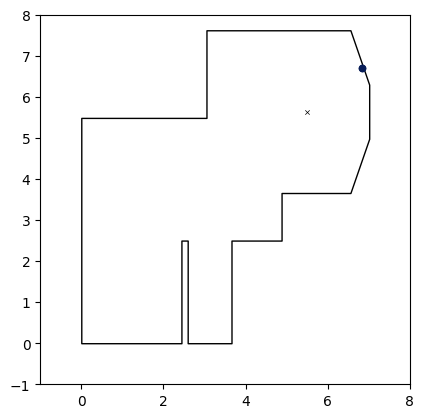

In [ ]:
# Display Room in 2D
room = pra.Room.from_corners(corners)
room.add_source(source[:2])
room.add_microphone(mic[:2])

fig, ax = room.plot(img_order=2)
ax.set_xlim([-1, 8])
ax.set_ylim([-1, 8])

# Define Materials

The materials used for the wall floor and ceiling will define the absorption, reflection, and scattering of sound. You have three options for defining the absorption properties of the materials.

1.   The most basic case is to enter a
single absorption coeffiecient like `pra.Material(energy_absorption=0.6, scattering=0.4)`
2. Browse for real materials in the [pyroomacoustics materials database](https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.materials.database.html) (with frequency depenendent absorption) which can be entered like:
`pra.Material('rockwool_50mm_80kgm3')`
3.   You can make your own frequency dependent absorption materials like: `pra.Material(energy_absorption={'coeffs':[0.1, 0.2, 0.4, 0.8, 0.99], 'center_freqs': [100, 250, 500, 1000, 10000]}, scattering=0.4)`

Note: I have noticed a bug in the frequency depenendent attenuation - best to stick to single absorption coefficients for now.



In [ ]:
wall_material = pra.Material(energy_absorption=0.5, scattering=0.25)
ceiling_material = pra.Material(energy_absorption=0.5, scattering=0.25)
floor_material = pra.Material(energy_absorption=0.05, scattering=0.25)

# Get Room Impulse Response

Now we will redefine the room in 3D using the "extrude" function, and then we will use pyroomacoustics to get a simulated impulse response of our room. This is a like a finger print and we can use it to get other things like the T60 (reverb decay) and Frequency Response.

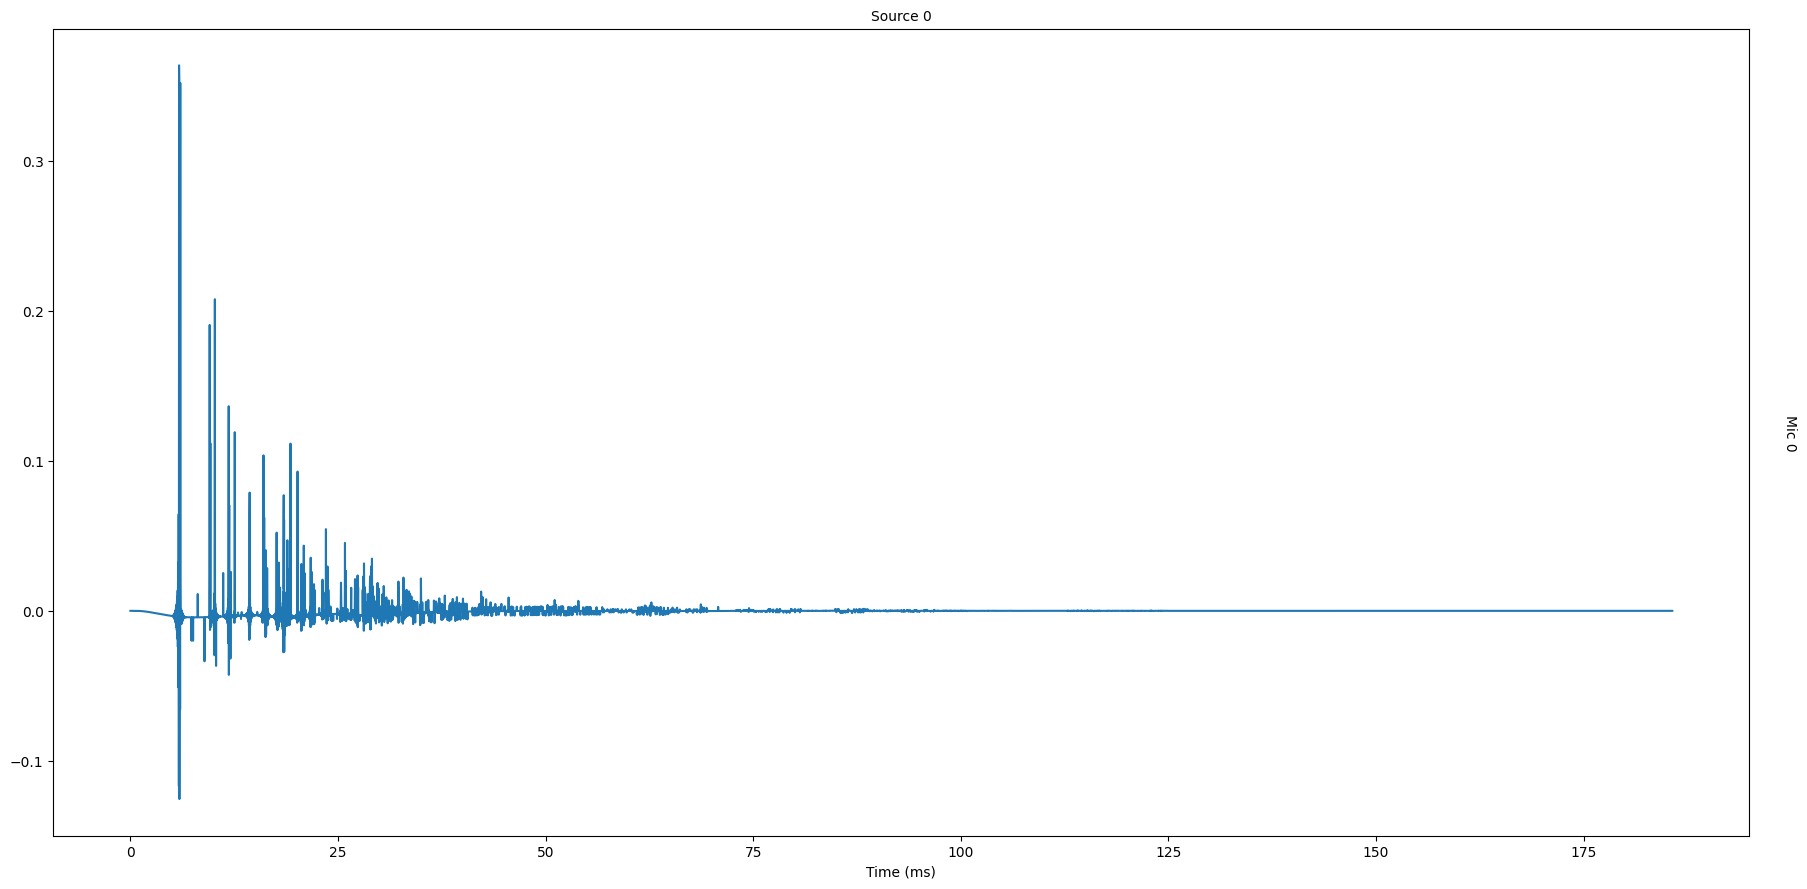

In [ ]:
from math import floor
# Redefine room for 3D raytracing simulation.
fs = 48000
room = pra.Room.from_corners(corners, fs=fs, max_order=5, materials=wall_material, ray_tracing=True, air_absorption=True)
room.extrude(h, materials=ceiling_material)
room.set_ray_tracing(receiver_radius=0.1, n_rays=10000, energy_thres=1e-7)
room.add_source(source)
room.add_microphone(mic)



# Compute image sources
room.image_source_model()
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

# Get T60

The T60 is the ammount of time for reverb to decay to -60dB. Specifically, if an impulse were sent into our room at 0db, this is how long it would take for the reflections of the the sound bouncing around the room towards the microphone to decay to -60db.

In [ ]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=False)
print(f"The RT60 is {t60 * 1000:.0f} ms")

The RT60 is 115 ms


# Get Frequency Response
The frequency response will tell us approximately how much our room boosts or attenuates certain frequencies. To do this we need to take the fourier transform (or FFT) of the impulse response.

The resolution of the FFT (number of discrete frequency bins) is dependent on the length of the impulse response. This is not good because as we fiddle with the parameters our FFT would have different resolutions. So, we are going to split our input signal into chunks and take the fourier transform of each chunk. This is essentially how a spectrogram works, except we are going to average the frames. But we will borrow tricks from spectrogram such as having the chunks overlap and using a smooth windowing function (like hamming window) to reduce artifacts caused by chunking.

Num Frequency Bins 21
Standard Deviation 2.1677731029903797
Min -5.781898118400605
Max 2.0974390412299164
Delta 7.879337159630522


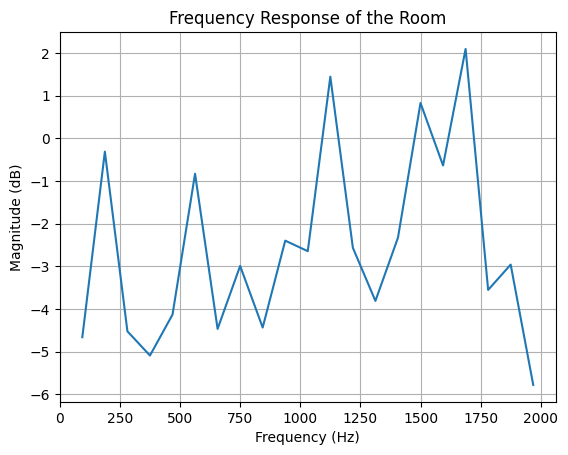

In [ ]:
# Define the chunk size.
chunk_size = 512
step_size = chunk_size // 2
min_freq = 20
max_freq = 2000

# Pad the impulse resonse so that our chunks start before and after the impulse response.
rir = room.rir[0][0]
rir = np.pad(rir, (step_size, len(rir) % chunk_size))


# Initialize an array to store the averaged frequency response
avg_freq_response = np.zeros(chunk_size, dtype=np.complex128)

# Apply Hamming window to each chunk, compute FFT, and average
for i, start_idx in enumerate(range(0, len(rir) - chunk_size, step_size)):
    end_idx = start_idx + chunk_size
    chunk = rir[start_idx:end_idx]

    # Apply Hamming window
    chunk *= hamming(chunk_size)

    # Compute FFT
    freq_response_chunk = np.fft.fft(chunk)
    avg_freq_response += freq_response_chunk

# Get frequency axis for our valid
freq_axis = np.fft.fftfreq(len(avg_freq_response), d=1/room.fs)

# Crop valid audible frequencies, so our statistics don't include inaudible frequencies
valid_freqs = np.logical_and(min_freq < freq_axis, freq_axis < max_freq)
freq_axis = freq_axis[valid_freqs]
freq_response = avg_freq_response[valid_freqs]
print('Num Frequency Bins', len(freq_axis))


# Convert to decibels
freq_response = 20 * np.log10(np.abs(freq_response))

print('Standard Deviation', freq_response.std())
print('Min', freq_response.min())
print('Max', freq_response.max())
print('Delta', freq_response.max() - freq_response.min())


# Plot the frequency response
plt.figure()
plt.plot(freq_axis, freq_response)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Frequency Response of the Room')
plt.grid(True)